In [1]:
from settings import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import pickle

collections = ["tarkus", "mambrino", "experto", "mini"]
files = ["data_tarkus.pkl", "data_mambrino.pkl", "data_experto.pkl", "data_mini.pkl"]
datasets = []
n = len(collections)
split = False

for i in range(0, n):
    try:
        with open(files[i], 'rb') as f:
            data_dict = pickle.load(f)
            datasets.append(data_dict)
    except Exception as e:
        print("Data file not found!")
        print(e)
    print(f"Found data for collection {collections[i]} with {len(data_dict)} entries, running analysis...")

Found data for collection tarkus with 983 entries, running analysis...
Found data for collection mambrino with 977 entries, running analysis...
Found data for collection experto with 986 entries, running analysis...
Found data for collection mini with 999 entries, running analysis...


In [2]:
# Split mini dataset into two (5x5 and 6x6)
if not split:
    data_mini = datasets[3]
    data_mini_5 = {}; data_mini_6 = {}
    for key, entry in enumerate(data_mini.values()):
        if(np.shape(entry['layout']) == (5,5)):
            data_mini_5[key] = entry
        elif(np.shape(entry['layout']) == (6,6)):
            data_mini_6[key] = entry

    n += 1; split = True
    collections[3] = "mini (5x5)"; collections.append("mini (6x6)")
    datasets[3] = data_mini_5; datasets.append(data_mini_6)
    print(f"Mini dataset has been split into 5x5 (n = {len(collections[3])}) and 6x6 (n = {len(collections[4])})")
print("Dataset was already split")

# Clean datasets and check if all dimensions are good
for i, df in enumerate(datasets):
    freq_sizes = {}
    for key, entry in df.items():
        layout_shape = np.shape(entry['layout'])
        if layout_shape not in freq_sizes:
            freq_sizes[layout_shape] = 0
        freq_sizes[layout_shape] += 1
    most_common_size = max(freq_sizes, key=freq_sizes.get)
    df = {key: entry for key, entry in df.items() if np.shape(entry['layout']) == most_common_size}
    datasets[i] = df
    

Mini dataset has been split into 5x5 (n = 10) and 6x6 (n = 10)
Dataset was already split


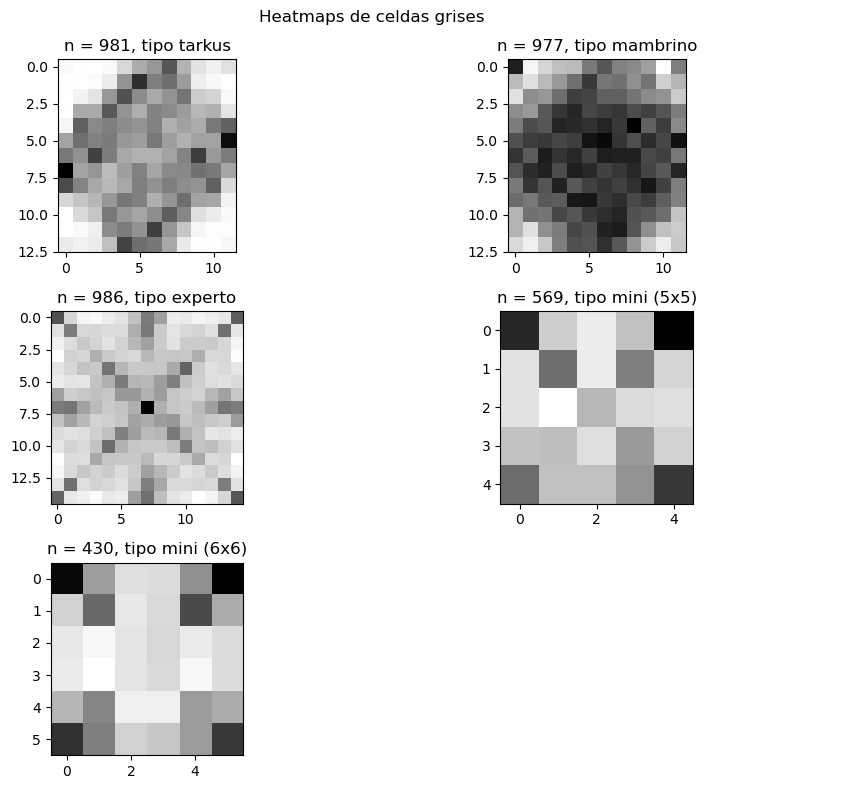

In [3]:
def plot_heatmap(data, data_name, axs, i):
    # Compute the probability matrix of a cell being prefilled (gray cell)
    first_layout_matrix = next(iter(data.values()))['layout']
    matrix_sum = np.zeros_like(first_layout_matrix, dtype=np.float64) 
    for entry in data.values():          
        layout_array = np.array(entry['layout'])
        matrix_sum += layout_array 
    matrix_sum = matrix_sum / len(data)

    # Plot the matrix as a heatmap
    axs[i // 2, i % 2].imshow(matrix_sum, cmap='gray_r', interpolation='nearest')
    axs[i // 2, i % 2].set_title(f'n = {len(data)}, tipo {data_name}')

fig, axes = plt.subplots(3, 2, figsize=(10, 8))
for i in range(0, n):
    plot_heatmap(datasets[i], collections[i], axes, i)
axes[-1, -1].axis('off')
plt.suptitle("Heatmaps de celdas grises")
plt.tight_layout()
plt.show()

In [4]:
from msgspec.json import decode
import numpy as np

WORDS_FILE = "es_wordlist.json"

with open(WORDS_FILE, "rb") as f:
    words_dict = decode(f.read())

words_freq = {key: int(value) for key, value in words_dict.items()}
total_sum = sum(words_freq.values())
print(total_sum)
words_freq_normalized = {key: value / total_sum for key, value in words_freq.items()}
print(list(words_freq_normalized.values())[0:5])

1030901626
[9.700246607235442e-10, 1.9400493214470884e-09, 9.700246607235442e-10, 1.9400493214470884e-09, 9.700246607235442e-10]


In [5]:
# Extract words from each of the datasets
from collections import Counter
import pandas as pd

# Iterate over entries in the dataset
words_datasets = {}
for j, dataset in enumerate(datasets):
    word_counter = Counter()
    for key, entry in dataset.items():
        df = []
        for i, pos in enumerate(entry['hclues_pos']):
            word = ''.join(entry['letters'][pos[0], pos[1]:pos[1] + entry['hclues_len'][i]])
            df.append(word)
        for i, pos in enumerate(entry['vclues_pos']):
            word = ''.join(entry['letters'][pos[0]:pos[0] + entry['vclues_len'][i], pos[1]])
            df.append(word)
        entry['words'] = np.array(df)
        word_counter.update(df)
    # Count the frequency of each word across entire dataset
    wordfreq = np.array(sorted(word_counter.items(), key=lambda x: x[1], reverse=True))
    words_datasets[collections[j]] = pd.DataFrame({'word': wordfreq[:,0], 'frequency': pd.to_numeric(wordfreq[:,1])})

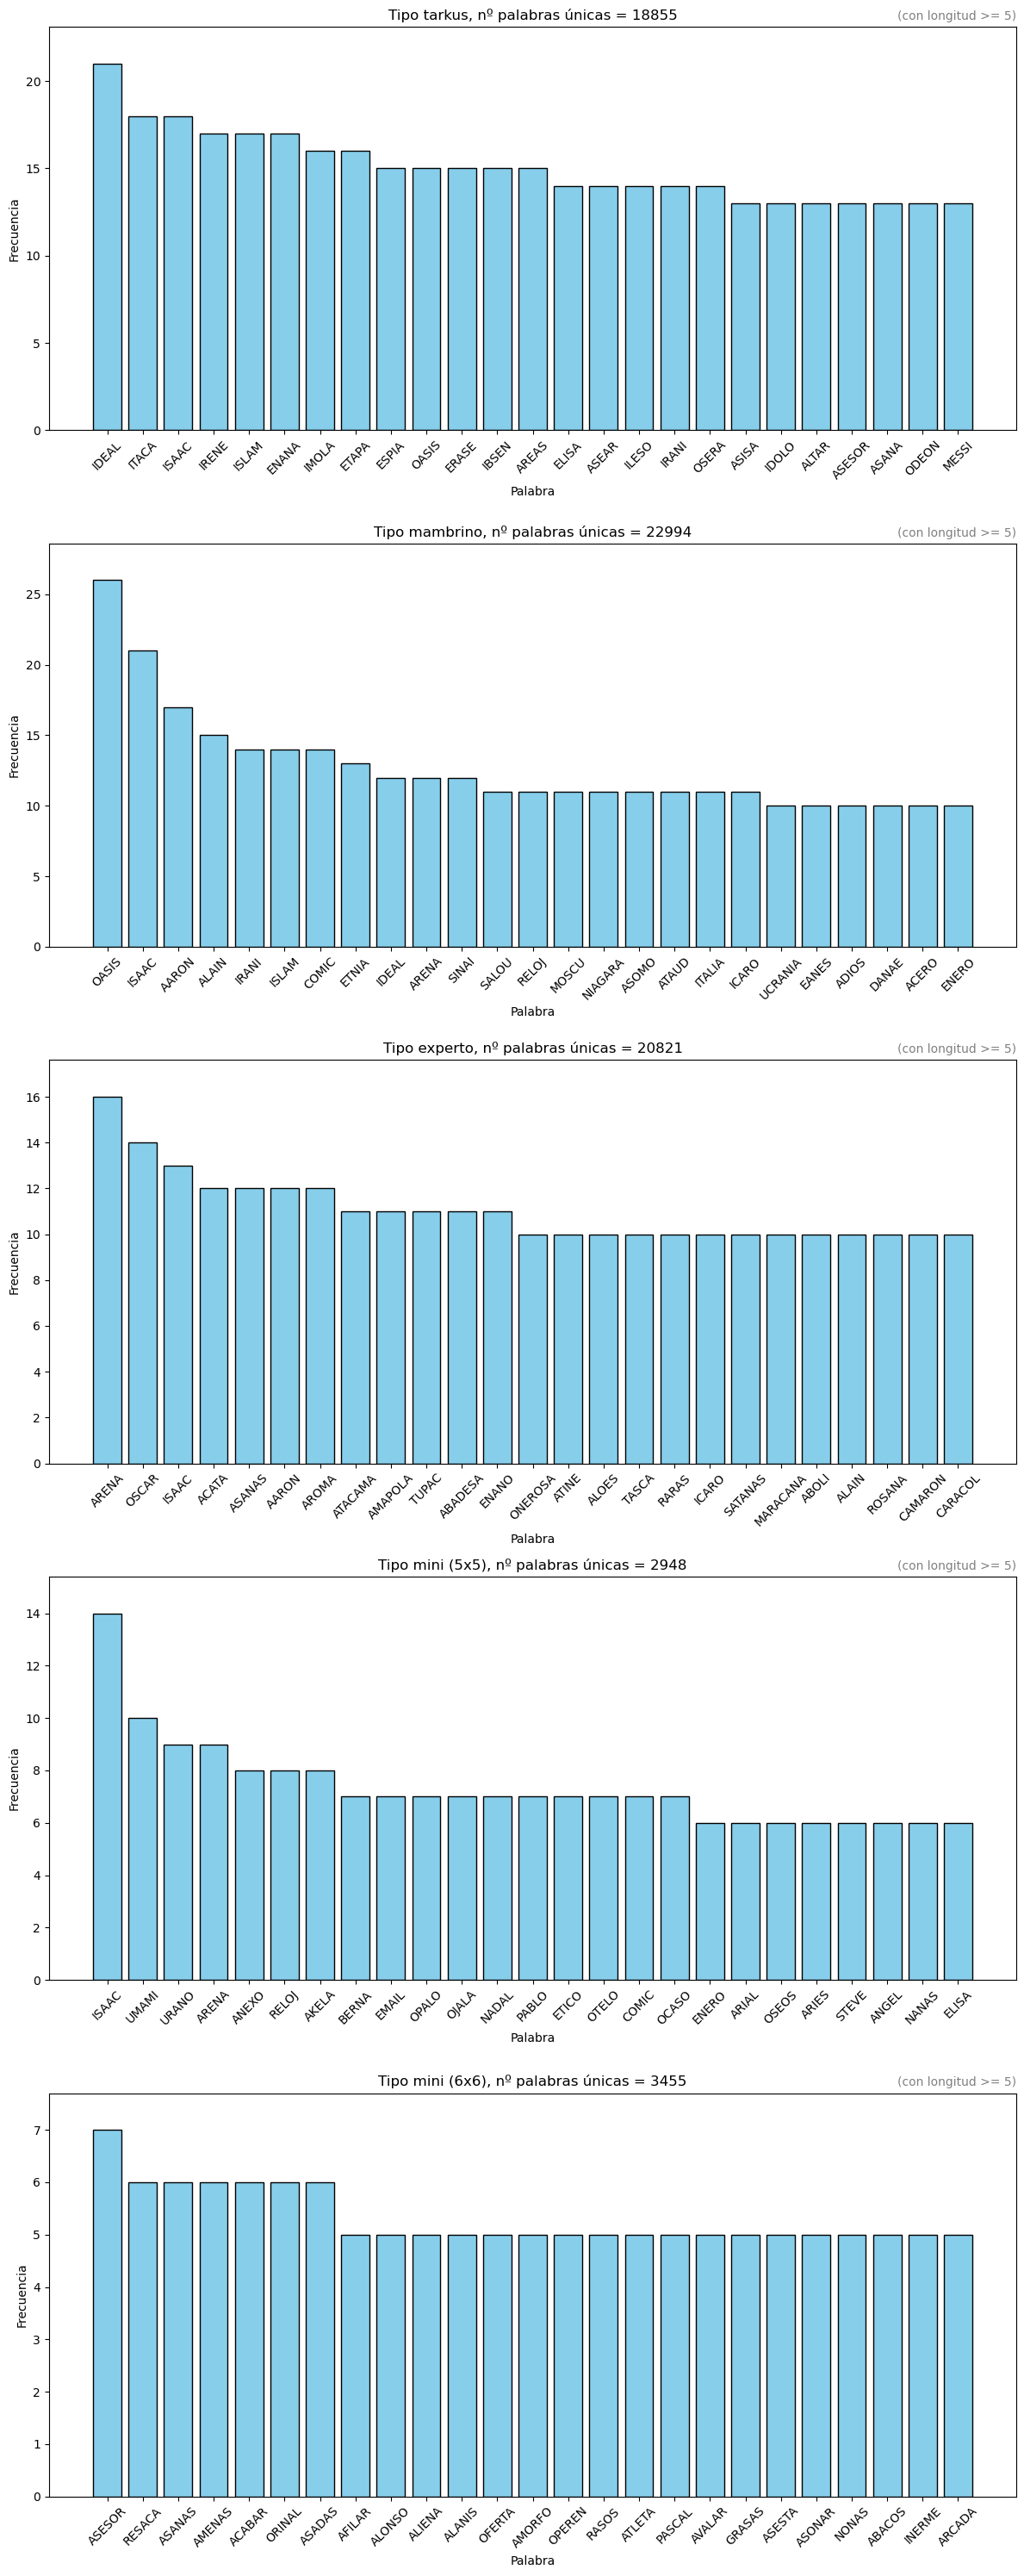

In [47]:
# Histograms for word frequency
from matplotlib.ticker import MaxNLocator
def plot_word_histogram(dataset, dataset_name, axes, i, len_filter, values, xlabel="Palabra", ylabel = "Frecuencia", typeint = False, extra_data_col=None):
    # Filter words with length >= len_filter
    data_filtered = dataset[dataset['word'].str.len() >= len_filter]
    data_filtered = data_filtered.head(25)  # Take top 25 words after filtering
    words = data_filtered['word']
    values = data_filtered[values]
    if(typeint):
        values = values.astype(int)
    
    axes[i].bar(words, values, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Tipo {dataset_name}, nº palabras únicas = {len(dataset)}')
    if len_filter >= 1:
        axes[i].set_title(f'(con longitud >= {len_filter})', loc='right', fontsize=10, color='gray')
    axes[i].set_xlabel(xlabel)
    axes[i].set_ylabel(ylabel)
    axes[i].set_xticks(np.arange(len(words)))
    axes[i].set_xticklabels(words, rotation=45, ha='center') 
    max_freq = values.max()
    axes[i].set_ylim(0, max_freq * 1.1)  # Adjust 1.1 factor as needed for padding
    if(extra_data_col is not None):
        for j, (freq, text_value) in enumerate(zip(values, df[extra_data_col])):
            axes[i].text(j, freq, text_value, ha='center', va='bottom', fontsize=8)

n = len(words_datasets)
fig, axs = plt.subplots(n, 1, figsize=(12, 6*n))

for i, (dataset_name, df) in enumerate(words_datasets.items()):
    plot_word_histogram(df, dataset_name, axs, i, 5, values = 'frequency', typeint=True)

plt.tight_layout()
plt.show()

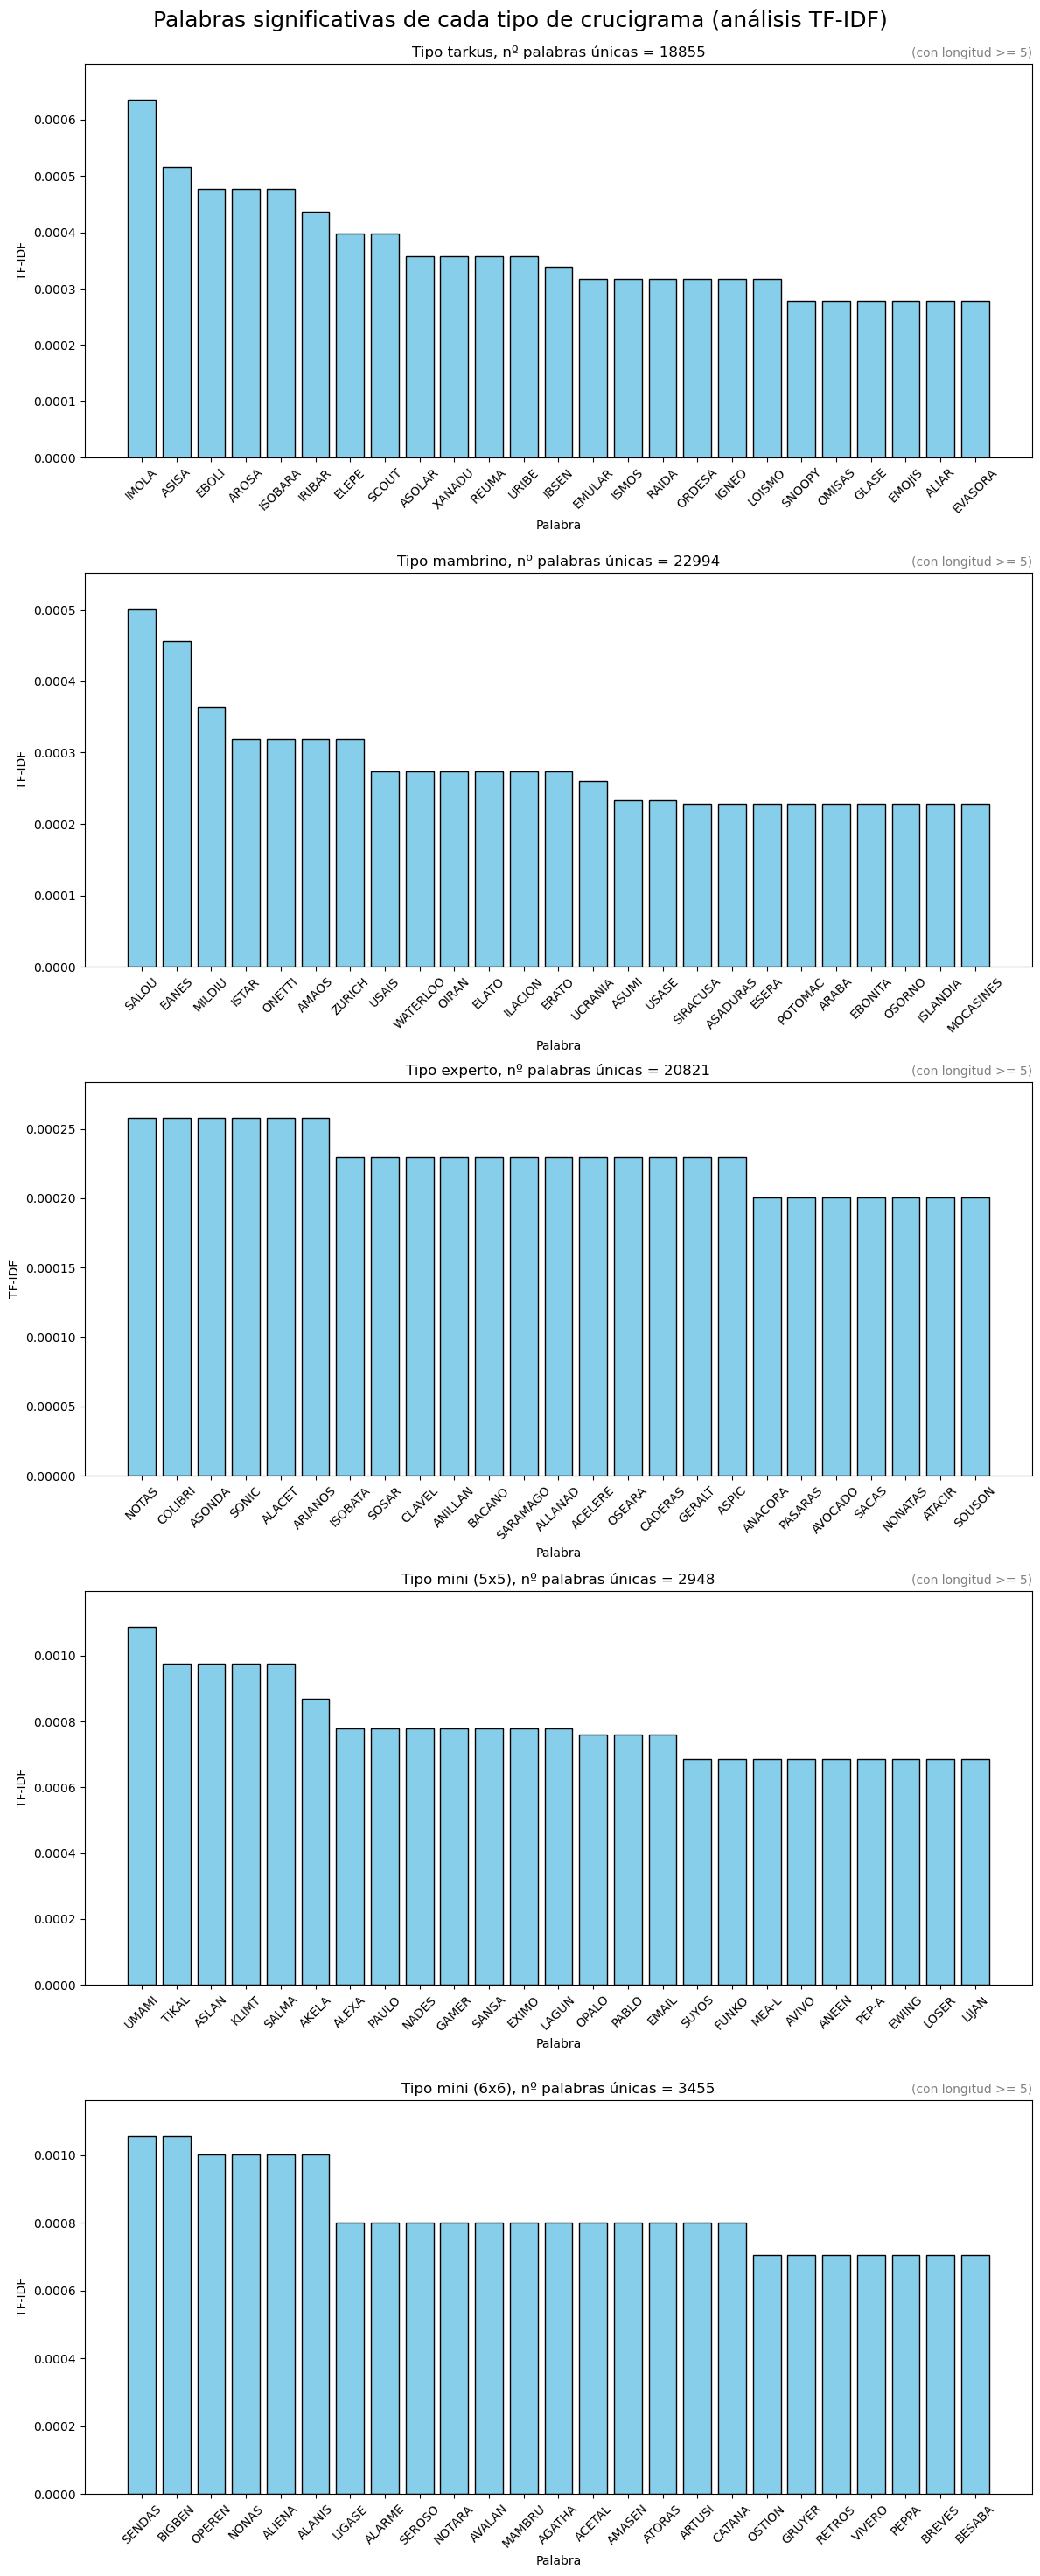

In [49]:
# Which words are more interesting for each author?
N = len(words_datasets)
for dataset_name, df in words_datasets.items():
    # Filter all word datasets out of 4 letter words
    df = df[df['word'].str.len() > 3].copy()  # Make a copy of the filtered DataFrame
    
    # Compute term frequency
    total_words = df['frequency'].sum()
    df.loc[:, 'tf'] = df['frequency'] / total_words  # Use .loc to modify original DataFrame
    
    # Update the DataFrame in words_datasets
    words_datasets[dataset_name] = df

# Compute IDF values
unique_words_appearances = Counter()
for dataset_name, df in words_datasets.items():
    # Update the appearance count for each unique word
    unique_words_appearances.update(set(df['word'].tolist()))
# Compute IDF values
num_documents = len(words_datasets)
idf_values = {word: np.log(num_documents / appearances) for word, appearances in unique_words_appearances.items()}

# Convert IDF values to DataFrame
idf_df = pd.DataFrame(list(idf_values.items()), columns=['word', 'idf'])
idf_df = idf_df.sort_values(by='idf', ascending=False)
idf_df.reset_index(drop=True, inplace=True)
idf_dict = idf_df.set_index('word')['idf'].to_dict()

# Iterate through each dataset
for dataset_name, df in words_datasets.items():
    # Calculate TF-IDF for each word in the dataset
    df['tfidf'] = df['tf'] * df['word'].map(idf_dict)
    # Update the DataFrame in words_datasets
    words_datasets[dataset_name] = df

# Create a figure with subplots
fig, axs = plt.subplots(n, 1, figsize=(12, 6*n))

# Iterate through each dataset and create a subplot for each one
for i, (dataset_name, df) in enumerate(words_datasets.items()):
    plot_word_histogram(df.sort_values(by=['tfidf'], ascending=False), dataset_name, axs, i, 5, values = 'tfidf', ylabel = "TF-IDF")
plt.suptitle("Palabras significativas de cada tipo de crucigrama (análisis TF-IDF)", fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.959)
plt.show()